# Pipeline Notebook 

## Imports

In [ ]:
import keras
import tensorflow as tf
import handwriting.preprocess as preprocess
import cv2

## Bounding Box

### Bounding Box Modell

## Show Image Real Image

In [ ]:
from bounding_box.model import load_weight_model,predict_image,get_image_as_array, show_image 
from bounding_box.config import NUM_CLASSES_ALL,BBOX_PATH,MAIN_BBOX_DETECTOR_MODEL,SUB_BBOX_DETECTOR_MODEL  
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data

bbox_model = load_weight_model(r"bounding_box\workspace\models\main_bbox_detector_model.h5",4)
image_path = "data_zettel/filled_resized/image_0006.jpg"
original_image = cv2.imread(image_path)

### Prediction

In [ ]:
main_boxes, confidence, classes = predict_image(image_path, bbox_model)
show_image(image_path, main_boxes, confidence, classes)  

### Templating

In [ ]:
org_ms_boxes_person, org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung, org_ms_boxes_wwa, person_class_ids, ausbildung_class_ids, wohnsitz_class_ids, wwa_class_ids, widthOrgImag, heightOrgImag = build_templating_data()

ausbildung, person, wohnsitz, wwa, best_predicted = get_templated_data(main_boxes, confidence, classes, org_ms_boxes_person,
                                                                       org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung,
                                                                       org_ms_boxes_wwa, person_class_ids,
                                                                       ausbildung_class_ids, wohnsitz_class_ids,
                                                                       wwa_class_ids)
top_cut = False
if top_cut:
    ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
else:
    ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut = edit_sub_boxes_cut_links(ausbildung, person, wohnsitz, wwa)


### Scale Templating up

In [ ]:
def scale_up(ausbildung, person, wohnsitz, wwa):
    return ausbildung, person, wohnsitz, wwa

In [ ]:
ausbildung_cut_scaled, person_cut_scaled, wohnsitz_cut_scaled, wwa_cut_scaled = scale_up(ausbildung_cut, person_cut, wohnsitz_cut, wwa_cut)
sub_boxes = ausbildung_cut_scaled[0] + person_cut_scaled[0] +  wohnsitz_cut_scaled[0] +  wwa_cut_scaled[0] 
sub_classes = ausbildung_cut_scaled[1] + person_cut_scaled[1] + wohnsitz_cut_scaled[1] +  wwa_cut_scaled[1]

In [ ]:
plot_image(image_path, ausbildung_cut_scaled, person_cut_scaled, wohnsitz_cut_scaled, wwa_cut_scaled, best_predicted)

### ROI Crop

In [ ]:
from collections import namedtuple
ImageInfo = namedtuple('ImageInfo', ['image', 'sub_class','value'])

# Crop ROI
import cv2
from bounding_box.ressize import resize_imaged_without_expand_dim
from bounding_box.config import YOLO_WIDTH, YOLO_HEIGHT
def crop(xmin, ymin, xmax, ymax, image_path):
    image = cv2.imread(image_path)
    image = resize_imaged_without_expand_dim(image, YOLO_WIDTH, YOLO_HEIGHT)
    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    # width = int(round(width))
    # height = int(round(height))
    # rowBeg = y
    # rowEnd = y + height
    # columnBeg = x
    # columnEnd = x + width
    imgCropped = image[ymin:ymax, xmin:xmax]
    return imgCropped

import matplotlib.pyplot as plt
images_info_cropped = []
for i,box in enumerate(sub_boxes):
    xmin, ymin, xmax, ymax = box
    imgCropped = crop(xmin, ymin, xmax, ymax, image_path)
    image_info = ImageInfo(image=imgCropped,sub_class=sub_classes[i],value="")
    images_info_cropped.append(image_info)
    PLOT = False
    if PLOT:
        plt.axis("off")
        plt.imshow(imgCropped)
        plt.show()


## Handwriting Recognition

### Preprocess Image

In [ ]:
import numpy as np
import utils.configs as cfg
config_path = "utils/configs.json"
config = cfg.Config(config_path)
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

img_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
preprocessed_image_infos = []
for image_info in images_info_cropped:
    image = image_info.image 
    image = np.mean(image, axis=2, keepdims=True)
    image = preprocess.distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    
    temp_sub_class = image_info.sub_class
    temp_image_info = ImageInfo(image=image,sub_class=temp_sub_class,value="")
    preprocessed_image_infos.append(temp_image_info)

### Plot Images

In [ ]:
plot_image = preprocessed_image_infos[9].image
plot_image = np.transpose(plot_image, (1, 0, 2))
plot_image = np.flipud(plot_image)
plt.imshow(plot_image[:, :, 0],cmap='gray')

# Show the plot
plt.show()

### Handwriting Recognition Neural Network

In [ ]:
from keras.models import load_model
import os
import handwriting.tokenizer as tokenizer
import pickle
# Load from pickle file
with open('iam_handwriting_model_characters.pkl', 'rb') as file:
    loaded_max_len, loaded_characters = pickle.load(file)

# Print loaded data
print("Loaded max_len:", loaded_max_len)
print("Loaded characters:", loaded_characters)

In [ ]:
from keras.layers import StringLookup
char_to_num = StringLookup(vocabulary=list(loaded_characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :loaded_max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def load_model_and_weights():
    model_weight_path = "models/model9v3_xl/model9v3_xl_weights.keras"
    model_path = "models/model9v3_xl/"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [ ]:
# Neural Network Handwriting
handwriting_model = load_model_and_weights()
prediction_model = keras.models.Model(handwriting_model.get_layer(name="image").input, handwriting_model.get_layer(name="dense2").output)

### Spell Checker

In [ ]:
def spell_checker(text):
    from spellchecker import SpellChecker
    spell = SpellChecker(language='de')
    words = [word for word in text.split(" ") if word != '']
    #Spellchecker
    corrected_text = ' '.join([spell.correction(word) if spell.correction(word) is not None else word for word in text.split()])
    return corrected_text
    

### Map Sub_Classes to String

In [27]:
import bounding_box.config as bounding_box_config
class_ids = bounding_box_config.class_ids

def map_sub_class_to_string_and_sort(class_number):
    temp_class_string = class_ids[class_number]
    
    not_class_list = ["Ausbildung_Klasse","Ausbildung","Person","Wohnsitz","Wohnsitz_waehrend_Ausbildung"]
    if temp_class_string not in not_class_list:
        return temp_class_string
    return -1
        

### Prediction

In [28]:
images_with_value = []
# Prediction
for i, preprocess_image in enumerate(preprocessed_image_infos):
    preds = prediction_model.predict(tf.expand_dims(preprocess_image.image, axis=0))
    pred_texts = decode_batch_predictions(preds)
    selected_pred_text = pred_texts[0]
    selected_pred_text = selected_pred_text.replace("|"," ")
    prediction_text = spell_checker(selected_pred_text)
    temp_sub_class = preprocess_image.sub_class
    temp_sub_class_string = map_sub_class_to_string_and_sort(temp_sub_class)
    if temp_sub_class_string != -1:
        temp_image_info = ImageInfo(image=preprocess_image.image,sub_class=temp_sub_class_string,value=prediction_text)
        images_with_value.append(temp_image_info)

1/1 [==============================] - 0s 60ms/step


# Plot Predicted Text and Image

In [29]:
def plot_evaluation(images): 
    for i,image in enumerate(images):
        pred_texts = image.value
        title = f"{image.sub_class}: {pred_texts}"
        plot_image = image.image
        plot_image = np.transpose(plot_image, (1, 0, 2))
        plot_image = np.flipud(plot_image)
        plt.title(title)
        plt.imshow(plot_image[:, :, 0],cmap='gray')
        plt.show()
    


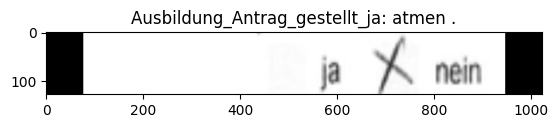

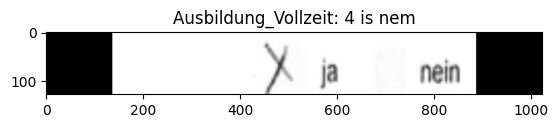

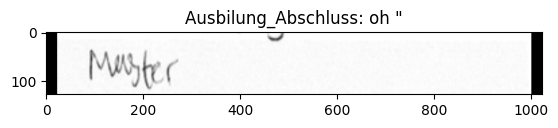

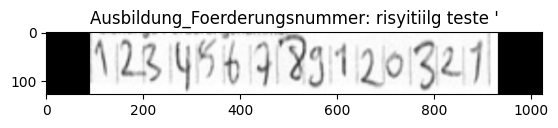

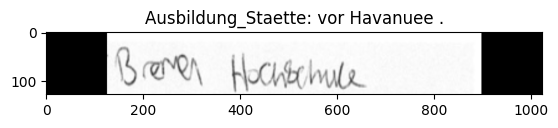

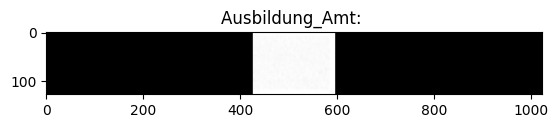

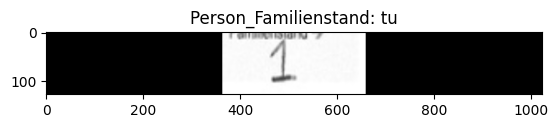

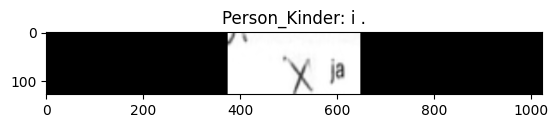

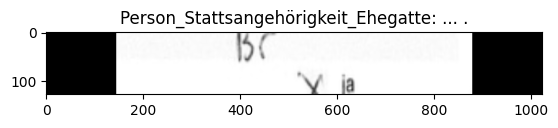

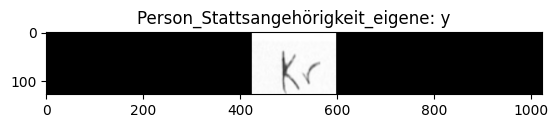

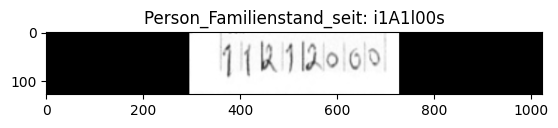

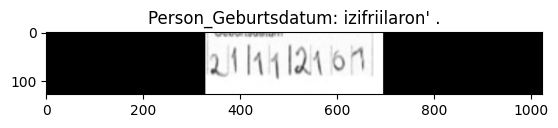

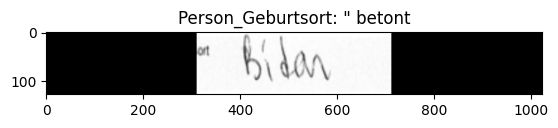

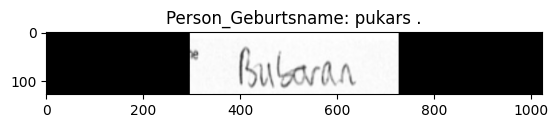

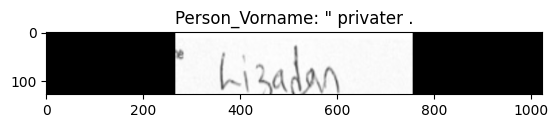

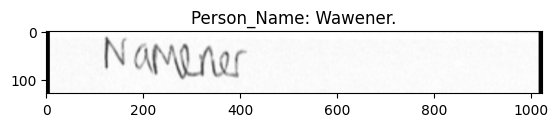

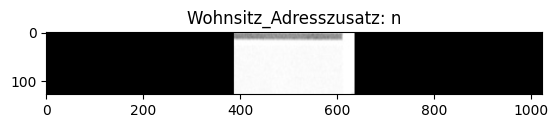

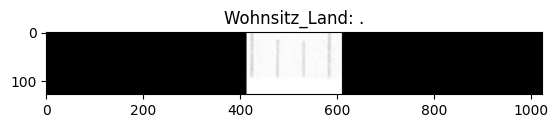

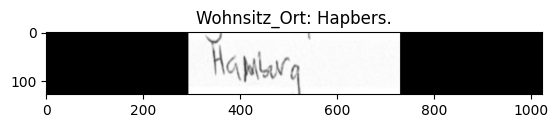

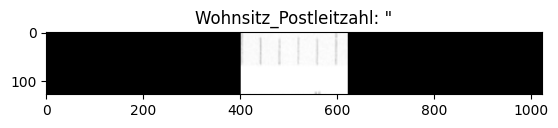

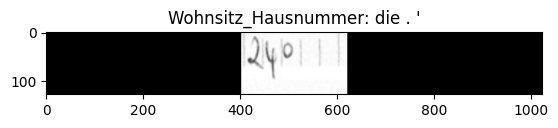

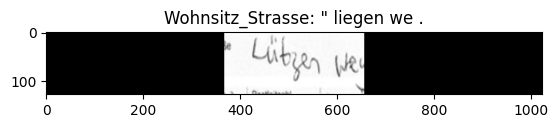

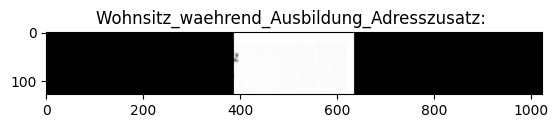

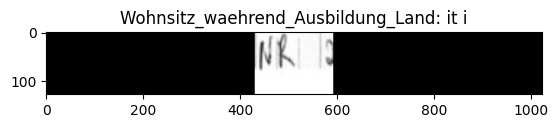

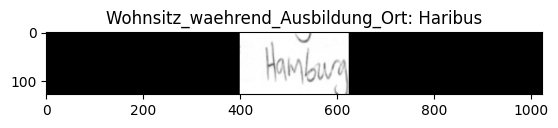

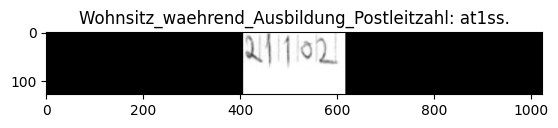

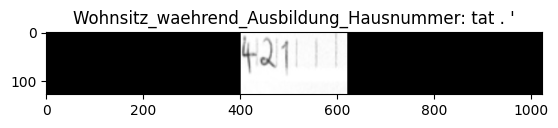

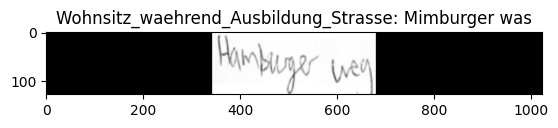

In [30]:
plot_evaluation(images_with_value)